### Preliminaries

We'll start with a review of the notation used to represent a dataset. In supervised learning we work with a dataset of $N$ labeled examples: $\mathcal{D} = \{ (\mathbf{x}_i, y_i) \}_{i=1}^N$, where $\mathbf{x}_i$ is a $d$-dimensional vector (we always use boldface to denote vectors), and $y_i$ is the label associated with $\mathbf{x}_i$.  Keep in mind that the formulation of the perceptron algorithm that we used relies on the labels are $\pm 1$, so make sure that is the case for the data you use!

In this assignment we will use the following datasets:


* The [QSAR](https://archive.ics.uci.edu/dataset/254/qsar+biodegradation) data for predicting the biochemical activity of a molecule.
* The [Wisconsin breast cancer dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). 
* The [Gisette](https://archive.ics.uci.edu/dataset/170/gisette) handwritten digit recognition dataset. For this dataset you are provided separate training/validation/test sets.  Since the test set doesn't come with labels, use the validation set for testing the classifier.
* The [heart disease diagnosis](https://archive.ics.uci.edu/dataset/45/heart+disease) dataset.
 

## Part 0:  Data Loaders

Write data loaders for each of the four datasets listed above.  Use the same API as you have done in assignment 1 for creating the penguins dataset.

For example, a function ```load_qsar``` should return a feature matrix X and labels vector y for this dataset.  Similarly for the other datasets.  For the ```load_breast_cancer``` function, you may use the scikit-learn function that creates the dataset.  Since the gisette dataset has separate training and validation sets (that you will use as training / test sets), you will need to write two data loaders - one for the training set, and one for the test set.  Note that you will need to convert the labels from the values 0,1 to $\pm 1$, since that is what our perceptron learning algorithm expects as label values.

#### A note on the heart disease diagnosis dataset
The heart disease diagnosis dataset has several data files associated with it.  The easiest would be to use [this file](http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data), where categorical variables have been replaced with numerical vaues.  The last column in the file contains the label associated with each example.  In the processed file, a label `0` corresponds to a healthy individual; other values correspond to varying levels of heart disease.  **In your experiments focus on the binary classification problem of trying to distinguish between healthy and non-healthy individuals.**


In [12]:
import numpy as np
import pandas as pd

In [13]:
def load_qsar():
    X = pd.read_csv('biodeg.csv', delimiter=';', usecols=range(0,41)).values
    y = pd.read_csv('biodeg.csv', delimiter=';', usecols=range(41,42)).values
    
    #change RB to 1 for biodegradable and NRB to -1 for non-biodegradable
    y[y == 'RB'] = 1
    y[y == 'NRB'] = -1
    
    return X,y.astype(int).flatten()

def load_breast_cancer():
    from sklearn.datasets import load_breast_cancer
    X,y = data = load_breast_cancer(return_X_y=True)
    
    #Changing 0s to -1
    y[y == 0] = -1
    
    return X,y

def load_gisette_train():
    X = pd.read_csv('gisette_train.data', delimiter=' ', header=None).values
    
    with open('gisette_train.labels', 'r') as file:
        lines = file.read().splitlines()
    y = np.array(lines, dtype=int)
    
    return X[:, :-1],y

def load_gisette_test():
    X = pd.read_csv('gisette_valid.data', delimiter=' ', header=None).values
    
    with open('gisette_valid.labels', 'r') as file:
        lines = file.read().splitlines()
    y = np.array(lines, dtype=int)
    
    return X[:,:-1],y

def load_heart():
    heart_data = pd.read_csv('heart_disease.csv', header=None, na_values=['?']).values
    #drop na
    heart_data_na = heart_data[~np.any(np.isnan(heart_data), axis=1)]
    
    X = heart_data_na[:, :-1]
    y = heart_data_na[:, -1].astype(int)
    
    #change 0 to 1 for healthy and anything above 0 to -1 for unhealthy
    y[y > 0] = -1
    y[y == 0] = 1
    
    return X, y


Use the following function to check that your function returns arrays of the appropriate shapes (you will need to determine how many features / examples each dataset contains).  The only case where this is somewhat of a challenge is the heart dataset, which contains some missing values.

In [14]:
def data_is_valid(X, y, examples=0, features=0):
    return (
        X.shape == (examples, features)
        and y.shape == (examples,)
        and not np.any(np.isnan(X))
        and np.all((y==1) | (y==-1))
    )

# for example:
heart_X, heart_y = load_heart()
print("validity for heart dataset: ", data_is_valid(heart_X, heart_y, examples=297, features=13))


validity for heart dataset:  True


## Part 1:  Evaluating the Perceptron on Real World Datasets

In this part of the assignment you will work with the perceptron algorithm and run it on two real-world datasets.  For comparison, you will also evaluate an [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) classifier on the same datasets.  We will cover SVMs in detail later in the course, and here you will simply use it with its default settings.

- Compare the performance of the  perceptron with the SVM classifier on the QSAR and breast cancer diagnosis datasets. Do so by estimating the accuracy on a sample of the data that you reserve for testing (the test set).  In each case reserve  70% of the data for training, and 30% for testing.  To gain more confidence in your error estimates, repeat this experiment using 10 random splits of the data into training/test sets for each algorithm.  Use the same train-test splits for each algorithm.  Report the average accuracy and its standard deviation in a nicely formatted table.  Is there a classifier among the two that appears to perform better?  In answering this, consider the differences in performance you observe in comparison to the standard deviation.  Make sure to let the perceptron algorithm run for a sufficient number of epochs.  In implementing this task, you may use a for loop to iterate over the 10 random splits.

A note about the classifier API:  in this course we follow the scikit-learn classifier API, which requires that a classifier have the following methods (in addition to a constructor):

* `fit(X, y)`:  trains a classifier using a feature matrix `X` and a labels vector `y`.
* `predict(X)`:  given a feature matrix `X`, return a vector of labels for each feature vector represented by `X`.

For those interested in more information about the scikit-learn API, here's a [link](https://scikit-learn.org/stable/developers/develop.html).


### A note about displaying your results

We recommend displaying the results of your experiments in the form of a automatically-generated table.  pandas DataFrame objects render nicely in Jupyter notebooks, and are an easy way to achieve this with minimal work.  Here's an example that you can use as a template:

In [15]:
data = [
    ['Perceptron', 0, 0],
    ['SVM', 0, 0],
    ['Perceptron', 0, 0],
    ['SVM', 0, 0],
]
pd.DataFrame(data, columns = ['Classifier', 'Mean', 'StdDev'])

,Classifier,Mean,StdDev
0,Perceptron,0,0
1,SVM,0,0
2,Perceptron,0,0
3,SVM,0,0


In [35]:
#Class for the implementation of the perceptron algorithm
from matplotlib import pyplot as plt

class perceptron :
    """An implementation of the perceptron algorithm.
    Note that this implementation does not include a bias term"""
 
    def __init__(self, iterations=100, learning_rate=0.2, 
                 plot_data=False, random_w=False, seed=42) :
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.plot_data = plot_data
        self.random_w = random_w
        self.seed = seed
  
    def fit(self, X, y) :
        """
        Train a classifier using the perceptron training algorithm.
        After training the attribute 'w' will contain the perceptron weight vector.
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
 
        y : ndarray, shape (n_examples,)
        Array of labels.
 
        """
        
        if self.random_w :
            rng = np.random.default_rng(self.seed)
            self.w = rng.uniform(-1 , 1, len(X[0]))
            print("initialized with random weight vector")
        else :
            self.w = np.zeros(len(X[0]))
            print("initialized with a zeros weight vector")
        self.wold = self.w
        converged = False
        iteration = 0
        while (not converged and iteration <= self.iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 :
                    self.wold = self.w
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
                    if self.plot_data:
                        self.plot_update(X, y, i)
            iteration += 1
        self.converged = converged
        if converged :
            print ('converged in %d iterations ' % iteration)
            
        X = X[:,:-1]
 
    def decision_function(self, x) :
        return np.dot(x, self.w)
 
    def predict(self, X) :
        """
        make predictions using a trained linear classifier
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
        """
 
        scores = np.dot(X, self.w)
        return np.sign(scores)
    
    def plot_update(self, X, y, ipt) :
        fig = plt.figure(figsize=(4,4))
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.arrow(0,0,self.w[0],self.w[1], 
                  width=0.001,head_width=0.05, 
                  length_includes_head=True, alpha=1,
                  linestyle='-',color='darkred')
        plt.arrow(0,0,self.wold[0],self.wold[1], 
                  width=0.001,head_width=0.05, 
                  length_includes_head=True, alpha=1,
                  linestyle='-',color='orange')
        anew = -self.w[0]/self.w[1]
        aold = -self.wold[0]/self.wold[1]
        pts = np.linspace(-1,1)
        plt.plot(pts, anew*pts, color='darkred')
        plt.plot(pts, aold*pts, color='orange')
        plt.title("in orange:  old w; in red:  new w")
        cols = {1: 'g', -1: 'b'}
        for i in range(len(X)): 
            plt.plot(X[i][0], X[i][1], cols[y[i]]+'o', alpha=0.6,markersize=5) 
        plt.plot(X[ipt][0], X[ipt][1], 'ro', alpha=0.2,markersize=20)

In [36]:
#Spliting the data into training set and test set
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_qsar, y_qsar = load_qsar()
X_breast, y_breast = load_breast_cancer()
qsar_data = [[],[]]
breast_cancer_data = [[],[]]

for i in range(10):
    X_qsar_train, X_qsar_test, y_qsar_train, y_qsar_test = train_test_split(X_qsar,y_qsar,test_size=0.3)
    X_breast_train, X_breast_test, y_breast_train, y_breast_test = train_test_split(X_breast,y_breast,test_size=0.3)
    
    p = perceptron(iterations=2000, learning_rate=0.1)
    svm = SVC()
    
    #For QSAR: Perceptron
    p.fit(X_qsar_train, y_qsar_train)
    y_pred = p.predict(X_qsar_test)
    qsar_data[0].append(np.mean(y_qsar_test == y_pred))
    #For QSAR: SVM
    svm.fit(X_qsar_train, y_qsar_train)
    svm_pred = svm.predict(X_qsar_test)
    qsar_data[1].append(np.mean(y_qsar_test == svm_pred))
    
    #For Breast Cancer: Perceptron
    p.fit(X_breast_train, y_breast_train)
    y_pred = p.predict(X_breast_test)
    breast_cancer_data[0].append(np.mean(y_breast_test == y_pred))
    #For Breast Cancer: SVM
    svm.fit(X_breast_train, y_breast_train)
    svm_pred = svm.predict(X_breast_test)
    breast_cancer_data[1].append(np.mean(y_breast_test == svm_pred))

qsar_data_array = np.array(qsar_data)
breast_cancer_data_array = np.array(breast_cancer_data)

performance_df = [
    ['Perceptron (QSAR)', np.mean(qsar_data_array[0,:]), np.std(qsar_data_array[0,:])],
    ['SVM (QSAR)', np.mean(qsar_data_array[1,:]), np.std(qsar_data_array[1,:])],
    ['Perceptron (BC)', np.mean(breast_cancer_data_array[0,:]), np.std(breast_cancer_data_array[0,:])],
    ['SVM (BC)', np.mean(breast_cancer_data_array[1,:]), np.std(breast_cancer_data_array[1,:])],
]

pd.DataFrame(performance_df, columns=['Classifier', 'Mean', 'StdDev'])


initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector


,Classifier,Mean,StdDev
0,Perceptron (QSAR),0.809779,0.068303
1,SVM (QSAR),0.812303,0.025676
2,Perceptron (BC),0.911696,0.034936
3,SVM (BC),0.908187,0.018129


*For the most part, the mean accuracy seems to be around the same value for both classifiers. I used multiple iterations as well, and the results were consistently alike. Sometimes, the percepton performed better, but for the most time, the SVM was more accurate. However, one of the most noticeable difference was with the standard deviation. The SVM always had a lower standard deviation, which implies that a higher percentage of the data was classified correctly. Overall, it seems like the SVM is a better indicator for its similar/higher accuracy and lower standard deviation.*

## Part 2:  Learning Curves 

Whenever we train a classifier it is useful to know if we have collected a sufficient amount of data for accurate classification.  A good way of determining that is to construct a **learning curve**, which is a plot of classifier performance as a function of the number of training examples.  Plot a learning curve for the perceptron algorithm using the [Gisette](http://archive.ics.uci.edu/dataset/170/gisette) handwritten digit recognition dataset. For this dataset use the separately provided validation set for testing your classifiers.  A test set is provided without its labels, so is not usable for us.
The x-axis for the plot (number of training examples) should be on a logarithmic scale - something like 10,20,40,80,200,400,800.  Use numbers that are appropriate for the dataset at hand, choosing values that illustrate the variation that you observe.  What can you conclude from the learning curve you have constructed for this particular dataset?
In answering this question, you can use the following [wikipedia article](https://en.wikipedia.org/wiki/Learning_curve#In_machine_learning).
Make sure that you use a fixed test set to evaluate performance while varying the size of the training set.


In [26]:
X_gisette_test, y_gisette_test = load_gisette_test()
X_gisette_train, y_gisette_train = load_gisette_train()

num_train = [10, 20, 40, 80, 200, 400, 800, 1600, 2400, 4800]
performance_gisette = []

for i in num_train:
    p = perceptron(iterations=1000, learning_rate=0.1)
    p.fit(X_gisette_train[:i,:], y_gisette_train[:i])
    y_pred = p.predict(X_gisette_test)
    performance_gisette.append(np.mean(y_gisette_test == y_pred))

initialized with a zeros weight vector
converged in 3 iterations 
initialized with a zeros weight vector
converged in 5 iterations 
initialized with a zeros weight vector
converged in 5 iterations 
initialized with a zeros weight vector
converged in 6 iterations 
initialized with a zeros weight vector
converged in 7 iterations 
initialized with a zeros weight vector
converged in 7 iterations 
initialized with a zeros weight vector
converged in 8 iterations 
initialized with a zeros weight vector
converged in 12 iterations 
initialized with a zeros weight vector
converged in 8 iterations 
initialized with a zeros weight vector
converged in 16 iterations 


Text(0, 0.5, 'Accuracy')

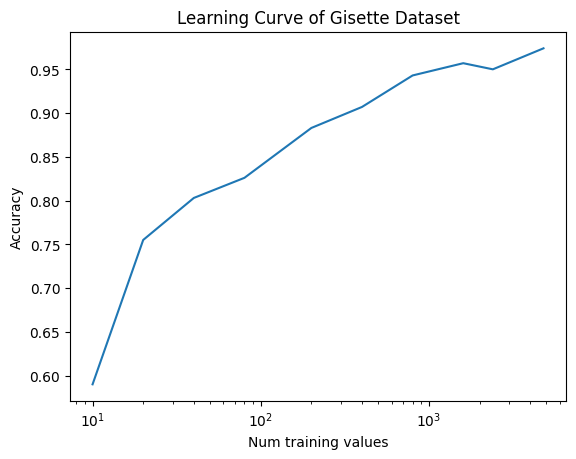

In [27]:
plt.figure()
plt.semilogx(num_train, performance_gisette)
plt.title('Learning Curve of Gisette Dataset')
plt.xlabel('Num training values')
plt.ylabel('Accuracy')

*The learning curve plotted above displays how the performance, or the accuracy, of the model increases as the number of training value increases. With more data, the model can learn more about the data, and improve its ability to classify data. I think it would be intersting to see how epochs would affect this test, since I would assume a larger set requires more epochs to reach a good solution. In practice, I think you could use this model to interpret what the ideal number of training values is for a dataset by looking at the start of a plateau.*

## Part 3:  Data standardization 

In this section we will explore the effect of normalizing the data, focusing on normalization of each feature individually.  In class we saw how to convert each column (i.e. feature) of a data matrix so that it fall in the range $[-1,1]$.  In this assignment we will explore a different approach callled **standardization**.

Here's what you need to do:

* Write a method to standardize a data matrix, so that each column has zero mean and standard deviation equal to 1.  This is done by subtracting the mean of each column, and dividing by its standard deviation.  See details [here](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)).  Scikit-learn has a method called [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) which does this.  Do not use it!  To demonstrate that your method works correctly, show that after standardization, your feature matrix has a zero mean and standard deviation equal to 1 for each column.  Make sure not to use for loops!

* Compare the accuracy of the standard perceptron on the heart dataset  with standardization and without it (make sure to evaluate the accuracy on a held out test set).  Like we did earlier, report the accuracy as the average over ten train-test splits.  Which leads to better performance?  Can you explain why?


In [28]:
X_heart, y_heart = load_heart()

#Calculating the mean and std of each column
mean_heart = np.mean(X_heart, axis=0)
std_heart = np.std(X_heart, axis=0)

#Subtracting the mean and dividing by std
X_heart_standard = X_heart - mean_heart
X_heart_standard = X_heart_standard / std_heart

#Validation of standardization
print('Mean of each column after standardization:')
print(np.mean(X_heart_standard, axis=0))
print('Standard Deviation of each column after standardization:')
print(np.std(X_heart_standard, axis=0))

Mean of each column after standardization:
[-1.05041303e-16 -2.78864100e-16 -4.63527458e-17  4.76143629e-16
 -2.36156026e-16  5.60718699e-17  1.97372982e-16  5.14365953e-16
 -2.50454352e-17 -2.79985537e-16  1.27096239e-17 -2.22792230e-16
 -1.16255677e-16]
Standard Deviation of each column after standardization:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [29]:
heart_data = [[],[]]

for i in range(10):
    X_heart_train, X_heart_test, y_heart_train, y_heart_test = train_test_split(X_heart,y_heart,test_size=0.3)
    X_heart_std_train, X_heart_std_test, y_heart_std_train, y_heart_std_test = train_test_split(X_heart_standard,y_heart,test_size=0.3)
    
    p = perceptron(iterations=10000, learning_rate=0.1)
    
    #for non-standard
    p.fit(X_heart_train, y_heart_train)
    y_pred = p.predict(X_heart_test)
    heart_data[0].append(np.mean(y_heart_test == y_pred))
    
    #for standard
    p.fit(X_heart_std_train, y_heart_std_train)
    y_pred = p.predict(X_heart_std_test)
    heart_data[1].append(np.mean(y_heart_std_test == y_pred))

initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector


In [30]:
heart_data_array = np.array(heart_data)

heart_df = [
    ['Non-standard', np.mean(heart_data_array[0,:]), np.std(heart_data_array[0,:])],
    ['Standard', np.mean(heart_data_array[1,:]), np.std(heart_data_array[1,:])],
]

pd.DataFrame(heart_df, columns=['Data', 'Mean', 'StdDev'])

,Data,Mean,StdDev
0,Non-standard,0.750000,0.088367
1,Standard,0.815556,0.040430


*With less iterations, there does seem to be a difference between the accuracy. Often, I got a .57 for non-standard and .75 for standard with iterations of 10 or 100. However, with more iterations, I noticed that the accuracy seem to be very similar, with both being within 3-4% of each other. I think standardization is more effective when the epochs are low, but as the iterations grow, the model learns more from the data and they both reach a point of plateau.*

### Your Report

Answer the questions in the cells reserved for that purpose.


### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the results and plots in your notebook.

### Grading 


```
Grading sheet for assignment 2
Part 0:  2 points
Part 1:  4 points
Part 2:  2 points
Part 3:  2 points
```

